# <center> Kaggle赛题 - 推特灾难型事件文本分类预测 </center>

## 1. 赛题介绍

目前，推特已经成为了紧急情况下的重要沟通渠道，智能手机的普及使得人们能够实时更新和宣布他们所观察到的紧急情况，比如一些自然灾害等。正因为如此，许多机构有兴趣通过程序监控推特上的推文（如救灾组织和新闻机构），当灾害来临，可以快速采取行动。然而，对于一个人所说的话是否真的预示着一场灾难并不总是很清楚，本次赛题的主要任务便是建立一个机器学习模型来预测哪些推文（tweet）是在描述一场真的灾难，属于文本二分类任务。



数据简介：  
相关数据集由kaggle官方提供，其特征包含以下几个部分：

- id 每篇推文的独特编码
- text 推文
- location 发送推文的位置（可以为空）
- keyword 每篇推文的关键词（可以为空）
- target 预测变量，1表示为灾难推文，0表示非灾难推文

赛题评价标准为f1值，本人也在此采用f1进行模型评估

## 2. 导入数据和相关的库

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid',font_scale=1.2)

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from collections import defaultdict
from collections import Counter
from itertools import chain

import re
import string
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import precision_score,recall_score,f1_score

import tensorflow as tf
import tensorflow_hub as hub
import tokenization

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras.optimizers import SGD

In [2]:
# 导入训练集与测试集

train = pd.read_csv('tweet_train.csv')
test = pd.read_csv('tweet_test.csv')

print('train set size:',train.shape)
print('test set size:',test.shape)

train set size: (7613, 5)
test set size: (3263, 4)


训练集有7613个样本，测试集有3263个样本

In [3]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


## 3. 数据分析

### 3.1 推文样本个数统计

target类别个数：
0    4342
1    3271
Name: target, dtype: int64


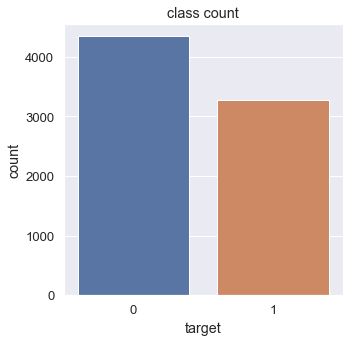

In [4]:
# target的分布情况

print('target类别个数：')
print(train['target'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(train['target'])
plt.title('class count')
plt.show()

在数据集中，0表示非灾害推文，1表示灾害推文。从结果看出，非灾害推文较多，有4342个，但总体来看，二者分类较为均匀。

### 3.2 推文词汇总量统计

In [13]:
# 统计词汇总量

list_2d = train['text'].str.split().tolist()

# 列表二维变一维
list_1d = list(chain.from_iterable(list_2d))          
print('总词汇量：{}'.format(len(list_1d)))

word_dict = Counter(list_1d)
print('不重复词汇量：{}'.format(len(word_dict)))
top10 = word_dict.most_common(10)
print(top10)                                           

总词汇量：113461
不重复词汇量：31924
[('the', 2575), ('a', 1845), ('to', 1805), ('in', 1757), ('of', 1722), ('and', 1302), ('I', 1197), ('for', 820), ('is', 814), ('on', 773)]


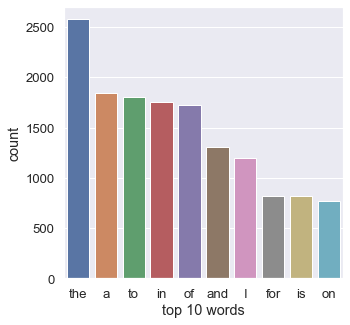

In [28]:
word = []
count = []
for i in top10:
    word.append(i[0])
    count.append(i[1])

df = pd.DataFrame({'词汇':word,'数量':count})    

plt.figure(figsize=(5,5))
sns.barplot(x=df['词汇'],y=df['数量'])
plt.xlabel('top 10 words')
plt.ylabel('count')
plt.show()

可以看出，出现频次最高的前10个单词都是停用词，也许对预测作用不大，后续会将其去除

### 3.3 不同推文的单词数量统计

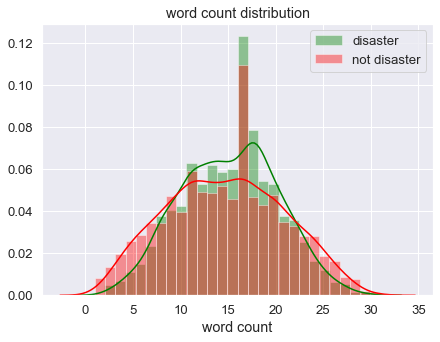

In [30]:
# 不同推文单词数分布

plt.figure(figsize=(7,5))

disaster_tweet = train[train['target']==1]
no_disaster_tweet = train[train['target']==0]

sns.distplot(disaster_tweet['text'].str.split().apply(lambda x: len(x)),
             color='green',label='disaster')

sns.distplot(no_disaster_tweet['text'].str.split().apply(lambda x: len(x)),
             color='red',label='not disaster')

plt.legend()
plt.xlabel('word count')
plt.title('word count distribution')
plt.show()

可见不管是灾害推文还是非灾害推文，所用词的数量大多集中在5-25个之间，少部分能到达30个左右

### 3.4 不同推文字符数统计

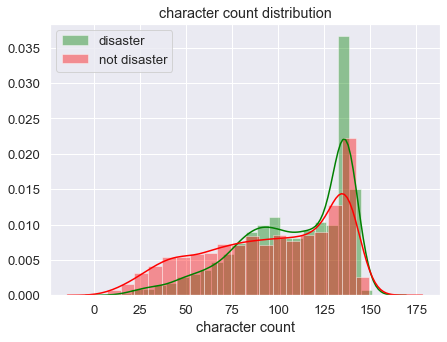

In [32]:
# 不同推文字符数分布

plt.figure(figsize=(7,5))

disaster_tweet = train[train['target']==1]
no_disaster_tweet = train[train['target']==0]

sns.distplot(disaster_tweet['text'].apply(lambda x: len(x)),
             color='green',label='disaster')

sns.distplot(no_disaster_tweet['text'].apply(lambda x: len(x)),
             color='red',label='not disaster')

plt.legend()
plt.xlabel('character count')
plt.title('character count distribution')
plt.show()

通过上述简单的分析，可知：

1. 训练集中非灾害型推文分类较多，不过二者大致上还是比较均匀的。
2. 赛题中每篇推文的字符个数平均有130个，还有一些推文字符较长。
3. 每篇推文的用到的词汇个数大多在5-25之间，由于句子较短，后续序列补全时长度不用太长。
4. 训练集使用了11w+的词汇量，数量占比前10的都是停用词，可以考虑去除。

## 4. 特征处理

In [3]:
train_new = train.copy()
test_new = test.copy()

随意展示10篇推文，可见推文中包含有url链接，非ASCII字符编码，标点符号，停用词等，都是需要清除的对象

In [4]:
train_new['text'].sample(10).tolist()

['So you have a new weapon that can cause un-imaginable destruction.',
 'The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@',
 'DT @georgegalloway: RT @Galloway4Mayor: \x89ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q',
 'Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.',
 'in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3',
 '@Calum5SOS you look like you got caught in a rainstorm this is amazing and disgusting at the same time',
 'my favorite lady came to our volunteer meeting\nhopefully joining her youth collision and i am excite http://t.co/Ij0wQ490cS',
 '@brianroemmele UX fail of EMV - people want to insert and remove quickly like a gas pump stripe reader. 1 person told me it crashed the POS',
 "Can't find my ariana grande shirt  this is a fucking tragedy"

In [5]:
def clean_text(text):
    """移除网页链接和非ASCII字符"""
    
    # 移除非ASCII字符
    sentence = ''.join([x for x in text if x in string.printable])
    
    # 移除URL链接
    sentence = re.sub(r"http\S+", "", sentence)
    
    return sentence

In [10]:
# 举个例子

text1 = 'please \x89 click http://t.co/wDUEaj8Q4J'
clean_text(text1)

'please  click '

In [6]:
# 移除emoji表情

def remove_emoji(text):
    """移除emoji表情"""
    emoji = re.compile("["
                      u"\U0001F600-\U0001F64F" 
                      u"\U0001F300-\U0001F5FF" 
                      u"\U0001F680-\U0001F6FF"
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      "]+",flags=re.UNICODE) 
    return emoji.sub(r'',text)

In [12]:
# 举个例子

text2 = 'another Earthquake 😔😔'
remove_emoji(text2)

'another Earthquake '

In [7]:
# 移除标点符号

def remove_punctuations(text):
    """移除标点符号"""
    for p in string.punctuation:
        text = text.replace(p,"")
    
    return text

In [14]:
# 举个例子

text3 = '...@hello, world!!!'
remove_punctuations(text3)

'hello world'

In [8]:
# 移除停用词

def remove_stopwords(text):
    """移除停用词"""
    words = [word for word in word_tokenize(text) if word not in stop]
    sentence = ' '.join(words)
    return sentence

In [16]:
# 举个例子

text4 = 'it is a Dog'
remove_stopwords(text4)

'Dog'

推文中还包含大量的缩写词，口语化用词，需要转换为标准单词，此处参考https://www.kaggle.com/rftexas/text-only-kfold-bert

In [9]:
# 缩写词纠正

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [10]:
def convert_abbrev(word):
    """转换缩写词为标准单词"""
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    """把推文中缩写词转换为标准单词"""
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [19]:
# 举个例子

text5 = 'It will spend 400$'
convert_abbrev_in_text(text5)

'It will spend 400  dollar '

In [11]:
train_new["text"] = train_new["text"].apply(lambda x: clean_text(x))
test_new["text"] = test_new["text"].apply(lambda x: clean_text(x))
    
train_new["text"] = train_new["text"].apply(lambda x: remove_emoji(x))
test_new["text"] = test_new["text"].apply(lambda x: remove_emoji(x))

train_new["text"] = train_new["text"].apply(lambda x: remove_stopwords(x))
test_new["text"] = test_new["text"].apply(lambda x: remove_stopwords(x))

train_new["text"] = train_new["text"].apply(lambda x: convert_abbrev_in_text(x))
test_new["text"] = test_new["text"].apply(lambda x: convert_abbrev_in_text(x))

train_new["text"] = train_new["text"].apply(lambda x: remove_punctuations(x))
test_new["text"] = test_new["text"].apply(lambda x: remove_punctuations(x))

## 5. 词向量与建模

### 5.1 TFIDF + 逻辑回归

In [21]:
# tfidf

tfidf = TfidfVectorizer()
train_text_vec = tfidf.fit_transform(train_new['text'])
test_text_vec = tfidf.transform(test_new['text'])

In [22]:
kfolds = KFold(n_splits=10,shuffle=True,random_state=42)

In [23]:
# 逻辑回归

param_grid = {'C':[1,2,3,4,5],'penalty':['l1','l2']}

lr = LogisticRegression(random_state=42)

gs = GridSearchCV(lr,param_grid=param_grid,scoring='f1',cv=kfolds)
gs = gs.fit(train_text_vec,train.target)

print(gs.best_params_,gs.best_score_)

{'C': 3, 'penalty': 'l2'} 0.7434945580999792


In [24]:
lr = LogisticRegression(C=3,random_state=42)
score = cross_val_score(lr,train_text_vec,train.target,scoring='f1',cv=kfolds)
print('f1平均分：{:.6}'.format(score.mean()))

f1平均分：0.743493


TFIDF和逻辑回归的组合比较简单，虽然TF-IDF通过单词频次和逆文档频率相乘的形式考虑到了单词的重要性，但基本没有考虑到上下文关系，这个评分也不是特别高

### 5.2 BERT

先定义一个评估标准，由于keras中的metric不包含f1值的API，故在此需要自己定义

In [12]:
class evaluation(Callback):
    def __init__(self,train_data=(),validation_data=()):
        self.x_train,self.y_train = train_data        
        self.x_valid,self.y_valid = validation_data
        
    def on_epoch_end(self,epoch,logs={}):
        """每一轮迭代后，计算presion,recall,f1值"""
        train_predict = np.round(self.model.predict(self.x_train))
        train_precision = precision_score(self.y_train,train_predict)
        train_recall = recall_score(self.y_train,train_predict)
        train_f1 = f1_score(self.y_train,train_predict)
        
        valid_predict = np.round(self.model.predict(self.x_valid))
        valid_precision = precision_score(self.y_valid,valid_predict)
        valid_recall = recall_score(self.y_valid,valid_predict)
        valid_f1 = f1_score(self.y_valid,valid_predict)
        
        print('train_precision: {:.5} - train_recall: {:.5} - train_f1: {:.5}'.format(
        train_precision,train_recall,train_f1))
        print('valid_precision: {:.5} - valid_recall: {:.5} - valid_f1: {:.5}'.format(
        valid_precision,valid_recall,valid_f1))

In [13]:
def bert_encode(texts, tokenizer, max_len=32):
    '''把文本处理成bert模型的输入'''
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [14]:
def build_model(bert_layer, dropout_num,learning_rate,momentum=0.9,max_len=32):
    '''搭建bert模型'''
    
    # 输入
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    # 输出
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    cls_output = sequence_output[:, 0, :]
    
    # 接一层全连接层，输出单元为1，激活函数为sigmoid，表示二分类
    if dropout_num == 0:
        out = Dense(1, activation='sigmoid')(cls_output)
    else:
        x = Dropout(dropout_num,seed=42)(cls_output)
        out = Dense(1, activation='sigmoid')(x)
    
    # 定义优化器
    optimizer = SGD(learning_rate=learning_rate,momentum=momentum)
    
    bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    bert_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return bert_model

In [15]:
# 导入预训练的BERT模型
bert_url = "https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
bert_layer = hub.KerasLayer(bert_url, trainable=True)

In [16]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [17]:
# 划分训练集和验证集
x_train,x_valid,y_train,y_valid = train_test_split(train_new,train_new['target'].values,
                                                   test_size=0.2,shuffle=True,random_state=42)
print(x_train.shape,x_valid.shape,y_train.shape,y_valid.shape)

(6090, 5) (1523, 5) (6090,) (1523,)


In [18]:
x_train_input = bert_encode(x_train.text.values, tokenizer)
x_valid_input = bert_encode(x_valid.text.values, tokenizer)
test_new_input = bert_encode(test_new.text.values, tokenizer)

In [19]:
x_train_input[0][0]

array([  101, 26103,  7481,  4106,  2342,  2224,  9593,  5968,  3386,
       20168, 19841,  2887,  2510,  4188,  7806,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [20]:
eva = evaluation(train_data=(x_train_input,y_train),validation_data=(x_valid_input,y_valid))

In [21]:
# 建立模型
model_BERT = build_model(bert_layer,dropout_num=0.2,learning_rate=0.0001)

In [22]:
# 开始训练
bert = model_BERT.fit(
    x_train_input, y_train,
    validation_data = (x_valid_input,y_valid),
    epochs = 3,
    verbose = 2,
    callbacks=[eva],
    batch_size = 8,
    shuffle=True
)

Epoch 1/3
train_precision: 0.84893 - train_recall: 0.74371 - train_f1: 0.79284
valid_precision: 0.83275 - valid_recall: 0.72881 - valid_f1: 0.77732
762/762 - 82s - loss: 0.5136 - accuracy: 0.7501 - val_loss: 0.4183 - val_accuracy: 0.8221
Epoch 2/3
train_precision: 0.90606 - train_recall: 0.72464 - train_f1: 0.80526
valid_precision: 0.88846 - valid_recall: 0.71186 - valid_f1: 0.79042
762/762 - 82s - loss: 0.4237 - accuracy: 0.8159 - val_loss: 0.3971 - val_accuracy: 0.8391
Epoch 3/3
train_precision: 0.85024 - train_recall: 0.81846 - train_f1: 0.83405
valid_precision: 0.80655 - valid_recall: 0.79661 - valid_f1: 0.80155
762/762 - 82s - loss: 0.3880 - accuracy: 0.8343 - val_loss: 0.3975 - val_accuracy: 0.8319


最终在训练集上的f1值为0.834，在验证集上为0.8015，有一点过拟合，不过其表现要比tfidf+逻辑回归要好不少

## 6. 预测

In [23]:
sample_sub = pd.read_csv('sample_submission.csv')

In [25]:
y_pre = model_BERT.predict(test_new_input)
y_pre = np.round(y_pre).astype(int).reshape(3263)
sub = pd.DataFrame({'id':sample_sub['id'].values,'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [26]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


参考kernel:

https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert    
https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert  
https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove  
https://www.kaggle.com/rftexas/text-only-kfold-bert